# Radar plot

Source: https://www.python-graph-gallery.com/web-circular-barplot-with-matplotlib

## Import the Data

In [1]:
import pandas as pd

df_covid_AP = pd.read_csv('../lung_pollution/data/covid_pollution_clean02.csv')

df_covid_AP.drop(columns=['Unnamed: 0'], inplace = True)
df_covid_AP = df_covid_AP.rename(columns={"PM2.5_annualMean": "PM2_5_annualMean", "fully_vaccinated": "Fully_vaccinated", "Population density": "Population_density"})

In [2]:
df_covid_AP.sort_values(['year'], axis=0, ascending=False,inplace=True,ignore_index=True)
df_covid_AP_2019 = df_covid_AP[0:400]

In [3]:
X = df_covid_AP_2019[['NO2_annualMean', 'NO_annualMean', 'O3_annualMean','PM2_5_annualMean', 'Fully_vaccinated', 'Population_density']]
y = df_covid_AP_2019[['cases_per_100k']]

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # Instanciate Robust Scaler

scaler.fit(X)  # Fit scaler to feature
scaled_num = scaler.transform(X)  #Scale
X = pd.DataFrame(scaled_num, columns = X.columns)

## Feature Permutation

In [5]:
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=205).fit(X, y) # Fit model

permutation_score = permutation_importance(model, X, y, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']



/tmp/ipykernel_1844/3604006230.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=205).fit(X, y) # Fit model


In [6]:
permutation = importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

permutation['R2 minus score'] = 0.88 - permutation['score decrease']

permutation

,feature,score decrease,R2 minus score
4,Fully_vaccinated,1.13421,-0.25421
5,Population_density,0.276093,0.603907
1,NO_annualMean,0.185987,0.694013
0,NO2_annualMean,0.145604,0.734396
3,PM2_5_annualMean,0.097512,0.782488
2,O3_annualMean,0.077886,0.802114


In [7]:
permutation = permutation.reset_index(drop=True)

In [8]:
permutation

,feature,score decrease,R2 minus score
0,Fully_vaccinated,1.13421,-0.25421
1,Population_density,0.276093,0.603907
2,NO_annualMean,0.185987,0.694013
3,NO2_annualMean,0.145604,0.734396
4,PM2_5_annualMean,0.097512,0.782488
5,O3_annualMean,0.077886,0.802114


In [9]:
permutation["feature"][0] = "Fully vaccinated"
permutation["feature"][1] = "Population density"
permutation["feature"][2] = "NO annual mean"
permutation["feature"][3] = "NO2 annual mean"
permutation["feature"][4] = "PM 2.5 annual mean"
permutation["feature"][5] = "O3 annual mean"
permutation

,feature,score decrease,R2 minus score
0,Fully vaccinated,1.13421,-0.25421
1,Population density,0.276093,0.603907
2,NO annual mean,0.185987,0.694013
3,NO2 annual mean,0.145604,0.734396
4,PM 2.5 annual mean,0.097512,0.782488
5,O3 annual mean,0.077886,0.802114


Text(0.1, 0.9, 'This Plot shows the R-square value in yellow and compares\nthis value with the score from each feature which is seen\nin the graph as the R-square minus the score')

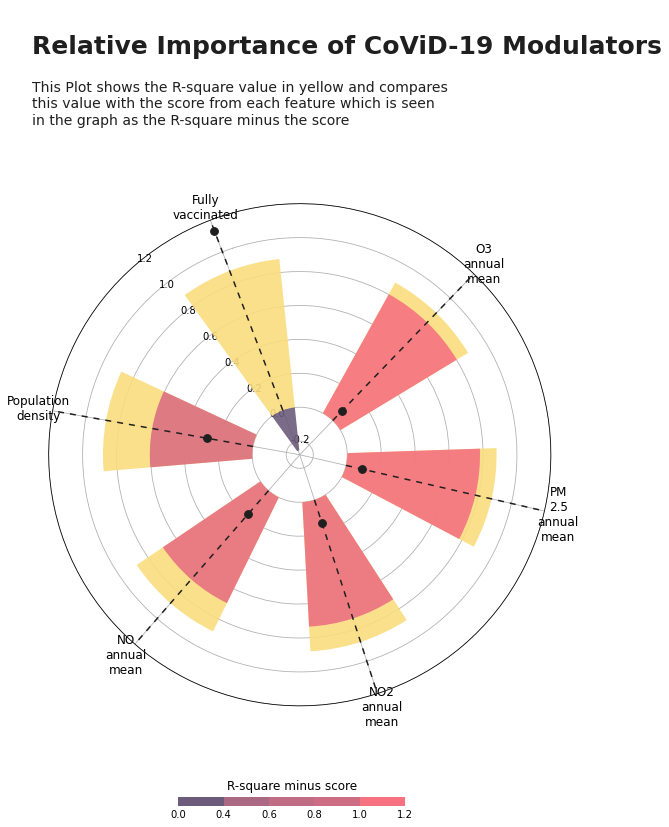

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

# Bars are sorted by the cumulative track length

# Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(permutation["R2 minus score"]), endpoint=False)

# R2 minus the score
SCORE_r2 = permutation["R2 minus score"].values

# Score
SCORE = permutation["score decrease"].values

# R2

R2 = 0.88

# Color setting

GREY12 = "#1f1f1f"

# Set default font to Bell MT
plt.rcParams.update({"font.family": "Bell MT"})

# Set default font color to GREY12
plt.rcParams["text.color"] = GREY12

# The minus glyph is not available in Bell MT
# This disables it, and uses a hyphen
plt.rc("axes", unicode_minus=False)

# Colors
COLORS = ["#6C5B7B","#C06C84","#C06C84", "#F67280"]

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS)

# Normalizer
norm = mpl.colors.Normalize(vmin=SCORE_r2.min(), vmax=SCORE_r2.max())

# Normalized colors. Each number of tracks is mapped to a color in the 
# color scale 'cmap'
#!!!Here I just read the norm(SCORE_r2) and entered the list below (inside cmap)
COLORS = cmap([0.0, 0.8250013268065529, 0.9082888782526887,
                   0.9405464278789125, 0.9870394386778917, 1.0])

# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-0.28, 1.2)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Add bars to represent the cumulative track lengths
ax.bar(ANGLES, SCORE_r2, color=COLORS, alpha=0.9, width=0.52, zorder=10)
ax.bar(ANGLES, R2, color='#fbdd7e', alpha=0.9, width=0.52, zorder=5)

# Add dashed vertical lines. These are just references
ax.vlines(ANGLES, 0, 3000, color=GREY12, ls=(0, (4, 4)), zorder=11)

# Add dots to represent the mean gain
ax.scatter(ANGLES, SCORE, s=60, color=GREY12, zorder=11)

permutation['feature'] = ["\n".join(wrap(r, 5, break_long_words=False)) for r in permutation['feature']]
permutation['feature']

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(permutation["feature"], size=12);
ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])

# Title

# First, make some room for the legend and the caption in the bottom.
fig.subplots_adjust(bottom=0.175)

# Create an inset axes.
# Width and height are given by the (0.35 and 0.01) in the 
# bbox_to_anchor
cbaxes = inset_axes(
    ax, 
    width="100%", 
    height="100%", 
    loc="center",
    bbox_to_anchor=(0.325, 0.1, 0.35, 0.01),
    bbox_transform=fig.transFigure # Note it uses the figure.
) 

# Create a new norm, which is discrete
bounds = [0, 0.4, 0.6, 0.8, 1.0, 1.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap), 
    cax=cbaxes, # Use the inset_axes created above
    orientation = "horizontal",

)



# Remove the outline of the colorbar
cb.outline.set_visible(False)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label and move it to the top (instead of default bottom)
cb.set_label("R-square minus score", size=12, labelpad=-40)


# Add annotations ------------------------------------------------



# Make some room for the title and subtitle above.
fig.subplots_adjust(top=0.8)

title = "\nRelative Importance of CoViD-19 Modulators"
subtitle = "\n".join([
    "This Plot shows the R-square value in yellow and compares",
    "this value with the score from each feature which is seen",
    "in the graph as the R-square minus the score",
 ])

fig.text(0.1, 0.93, title, fontsize=25, weight="bold", ha="left", va="baseline")
fig.text(0.1, 0.9, subtitle, fontsize=14, ha="left", va="top")


